# Contents

In this notebook, we will learn how to load the PKIS2 dataset into memory using a `DatasetProvider` object. Then we will apply some standard featurization to obtain ML-compatible representations, and use a simple model to compute some activity predictions.

1. [X] Loading the data
2. [X] Featurizing the data
3. [ ] Exporting the featurized data to PyTorch
4. [ ] Build and train the model
5. [ ] Analyze results nicely

Disable stereochemistry _warnings_ generated by `openforcefield`.

In [1]:
import warnings
warnings.simplefilter("ignore") 
import logging
logging.basicConfig(level=logging.ERROR)

# 1. Loading the data as a DatasetProvider

In [2]:
from kinoml.datasets.kinomescan.pkis2 import PKIS2DatasetProvider

RDKit WARNING: [10:49:17] Enabling RDKit 2019.09.2 jupyter extensions


Let's initialize the PKIS2 dataset provider. Instead of a regular `ClassName()` instantiation, we need to use `.from_source()` (with convenient default arguments).

__Why?__

This due to the design of `BaseDatasetProvider.__init__`, which expects a list of `System` objects (or subclasses of). A `System` object is a set of one more or `MolecularComponent` objects and a `BaseMeasurement`.

* The `MolecularComponent` class is the base object all proteins and ligands, regardless their representation (e.g. sequence vs 3D structure, smiles vs molecular graph). `MolecularComponent` is immediately subclassed by:
  * `BaseProtein`, the abstract model which is subclassed by more concrete classes, like `AminoAcidSequence` and `ProteinStructure`.
  * `BaseLigand`, the abstract model which is subclassed by more concrete classes, like `Ligand` (based on `openforcefield.topology.Molecule`).
* A `System` is abstract enough to not impose any restrictions on the composition, but its subclasses can be. 
  * This is the case of the `Complex` object, which requires at least one `BaseProtein` and one `BaseLigand` objects.
* A `BaseMeasurement` class is normally subclassed by more specific measurements (like `BaseMeasurement`), but the design is the same. It takes:
  * `values`: an array of numeric values (single measurements are _arrayfied_ into single-element arrays). This can be replicates of the value for statistical purposes, or under different concentrations of a reactant?
  * `conditions`: instance of `AssayConditions`. This class provides all the properties required to reproduce the experiment (say `pH`, `temperature`, `concentration`, etc). This should be paired (somehow) to the dimensionality of `values`, but I haven't though much of that yet.

Anyway, all those details are not needed to start using the provider. Right now there's no lazy behavior, so it will take _a bit_ to build all sequences and ligands. In my machine, it's about 80 seconds for all 160K datapoints.

In [3]:
%%time
provider = PKIS2DatasetProvider.from_source()

AssertionError: A ProteinLigandComplex must specify at least one Ligand and one Protein

> The image below shows the timing breakdown (obtained with `cProfile` on 2020.04.20). Apparently, most of the time is used to do Pandas operations, which is unxpected! I would have expected the bottleneck to be in the SMILES initialization or similar. Something to look into.

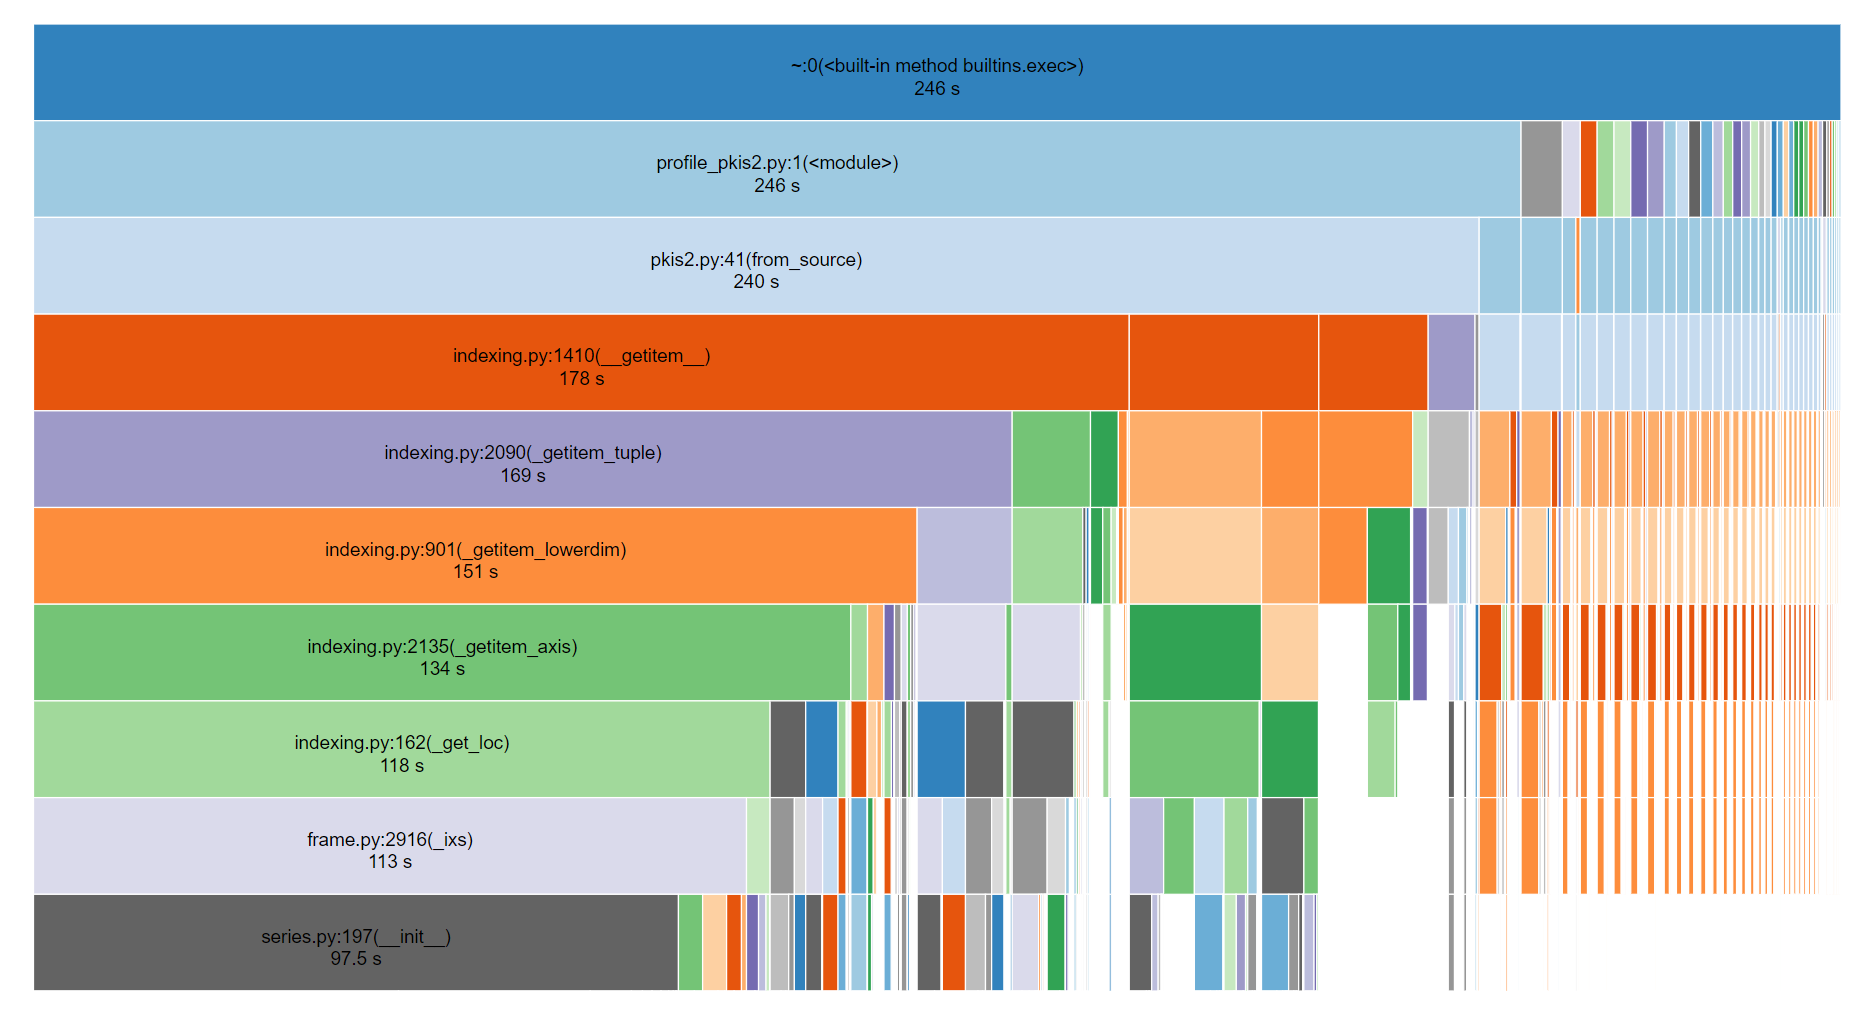

> This is due to `df.iloc` safety checks. Converting the df to a lists of lists avoids the slowdown but we have to make sure we are not introducing any access-by-wrong-index bugs! The nice news: we go from 240s to 27s (slowed-down because of the cProfile overhead; actual timing is more like 15s).

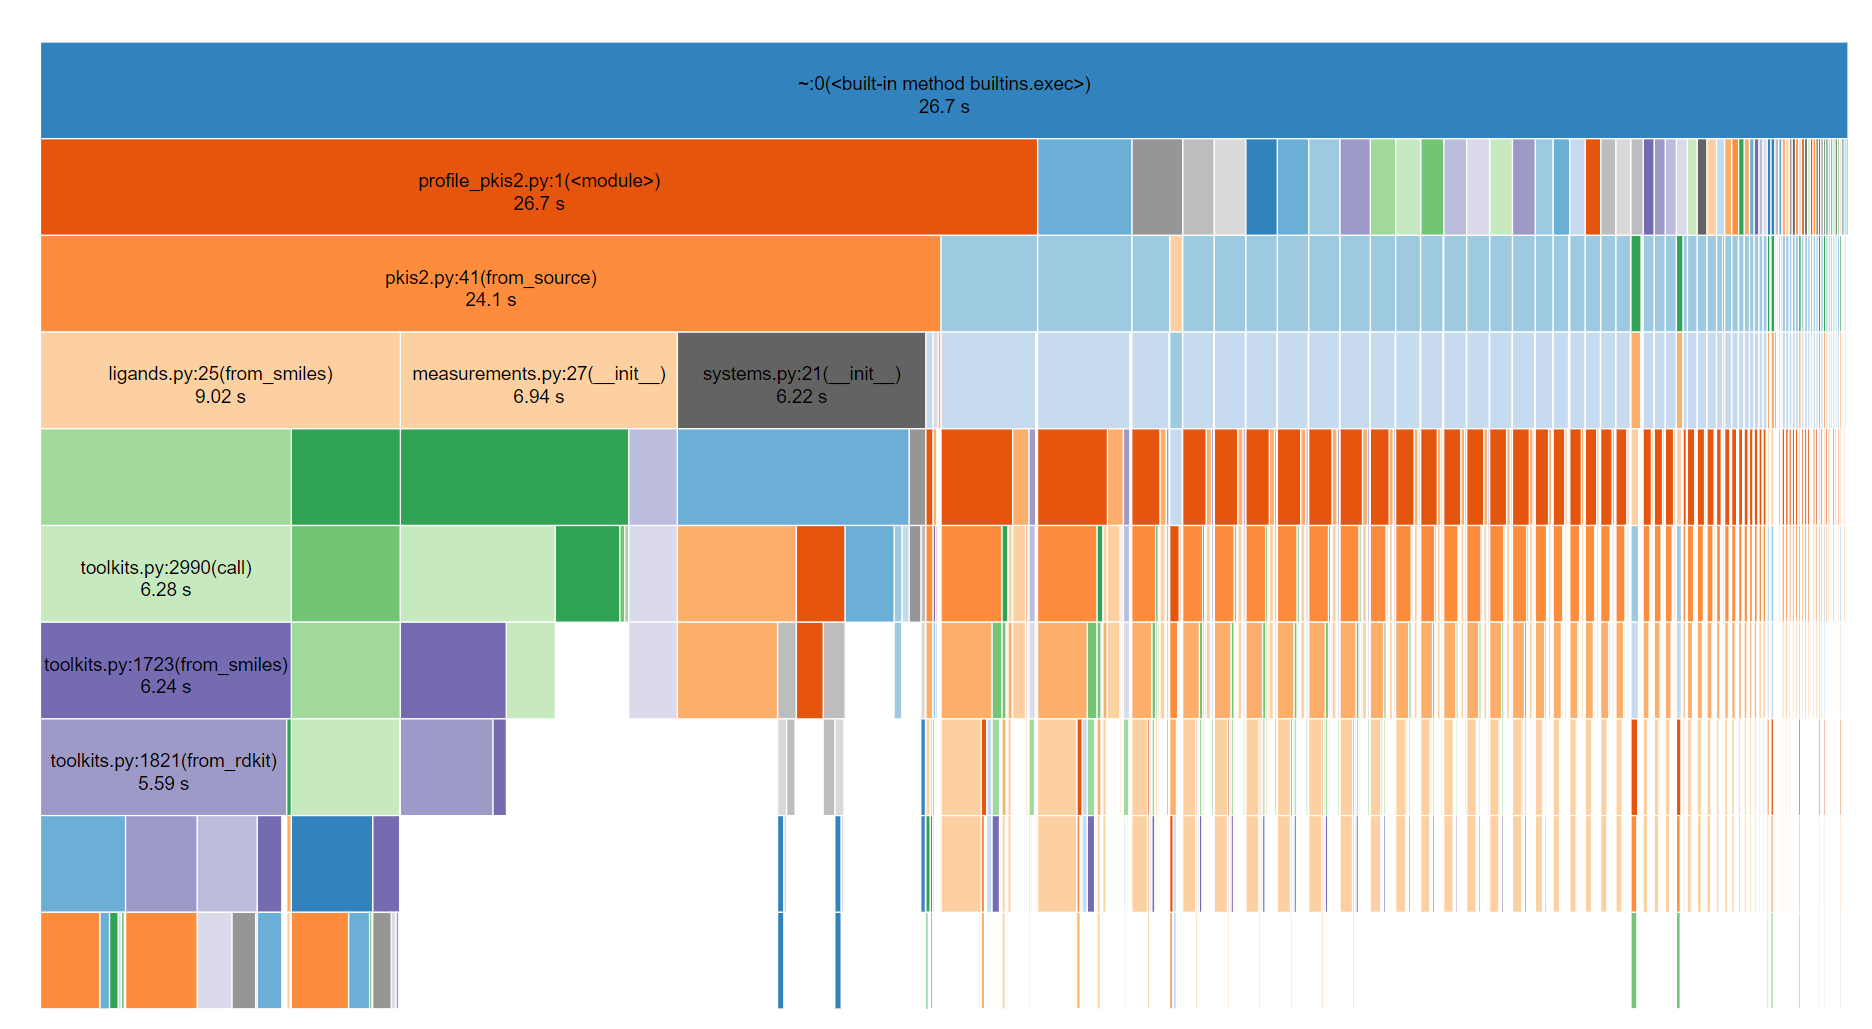

You can export a convenient dataframe with this method. Take into account this is just using the default implementation in the base class, which relies on the different `__repr__` methods and `.name` attributes of the objects involved. For prettier dataframes, one can always subclass `to_dataframe` to provide a better presentation.

In [4]:
df = provider.to_dataframe()
df

,ProteinLigandComplex,n_components,Avg PercentageDisplacementMeasurement
0,AAK1 & Clc1cccc(Cn2c(nn3c2nc(cc3=O)N2CCOCC2)C2...,2,14.0
1,ABL1-nonphosphorylated & Clc1cccc(Cn2c(nn3c2nc...,2,28.0
2,ABL1-phosphorylated & Clc1cccc(Cn2c(nn3c2nc(cc...,2,20.0
3,ABL2 & Clc1cccc(Cn2c(nn3c2nc(cc3=O)N2CCOCC2)C2...,2,5.0
4,ACVR1 & Clc1cccc(Cn2c(nn3c2nc(cc3=O)N2CCOCC2)C...,2,0.0
...,...,...,...
261865,ZAP70 & CCn1c(nc2c(nc(OC[C@H](N)c3ccccc3)cc12)...,2,0.0
261866,p38-alpha & CCn1c(nc2c(nc(OC[C@H](N)c3ccccc3)c...,2,0.0
261867,p38-beta & CCn1c(nc2c(nc(OC[C@H](N)c3ccccc3)cc...,2,0.0
261868,p38-delta & CCn1c(nc2c(nc(OC[C@H](N)c3ccccc3)c...,2,0.0


Notice how the string representations try to be a bit informative.

In [5]:
provider

<PKIS2DatasetProvider with 261870 systems>

In [6]:
s = provider.systems[0]
s

<ProteinLigandComplex with 2 components (<AminoAcidSequence name=AAK1>, <Ligand name=Clc1cccc(Cn2c(nn3c2nc(cc3=O)N2CCOCC2)C2CC2)c1Cl>) and <PercentageDisplacementMeasurement values=14.0 conditions=<AssayConditions pH=7.0>>>

Some areas do need improvement... this is how you get all the entries that have wild-type kinases (all of them in PKIS2). Maybe some Django-style queries?

In [7]:
import math
wt = [s for s in provider.systems if s.protein._provenance["mutations"] is None]
wt_provider = PKIS2DatasetProvider(systems=wt)
wt_provider

<PKIS2DatasetProvider with 261870 systems>

#  2. Featurizing the data

We will be using:

- MorganFingerprint n=2048 bits, r=2
- OneHotEncoding of protein sequence
- ... or composition of binding site

An isolated featurizer takes one system and returns the raw data:

In [17]:
from kinoml.features.ligand import MorganFingerprintFeaturizer
featurizer = MorganFingerprintFeaturizer(nbits=2048, radius=2)
fp = featurizer.featurize(provider.systems[0])
print(fp.shape, *fp[:100], "...")

(2048,) 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 ...


In the context of a dataset provider, each system will store that raw data in an internal dictionary (`.featurizations`) for _each_ system. Without caching, this would take ~30 minutes, given the huge amount of duplication in the dataset. Thanks to LRU caching at the `featurizer` level, each `Ligand` is only featurized once!

In [9]:
%%time
provider.featurize(featurizer)

Featurizing systems...: 100%|██████████| 261870/261870 [00:48<00:00, 5430.64it/s] 

CPU times: user 48.3 s, sys: 141 ms, total: 48.5 s
Wall time: 48.2 s


In [13]:
for system in provider.systems[:5]:
    print(system, "...\n  ", system.featurizations, "\n")

<ProteinLigandComplex with 2 components (<AminoAcidSequence name=AAK1>, <Ligand name=Clc1cccc(Cn2c(nn3c2nc(cc3=O)N2CCOCC2)C2CC2)c1Cl>) and <PercentageDisplacementMeasurement values=14.0 conditions=<AssayConditions pH=7.0>>> ...
   {'MorganFingerprintFeaturizer': array([0, 0, 0, ..., 0, 0, 0]), 'last': array([0, 0, 0, ..., 0, 0, 0])} 

<ProteinLigandComplex with 2 components (<AminoAcidSequence name=ABL1-nonphosphorylated>, <Ligand name=Clc1cccc(Cn2c(nn3c2nc(cc3=O)N2CCOCC2)C2CC2)c1Cl>) and <PercentageDisplacementMeasurement values=28.0 conditions=<AssayConditions pH=7.0>>> ...
   {'MorganFingerprintFeaturizer': array([0, 0, 0, ..., 0, 0, 0]), 'last': array([0, 0, 0, ..., 0, 0, 0])} 

<ProteinLigandComplex with 2 components (<AminoAcidSequence name=ABL1-phosphorylated>, <Ligand name=Clc1cccc(Cn2c(nn3c2nc(cc3=O)N2CCOCC2)C2CC2)c1Cl>) and <PercentageDisplacementMeasurement values=20.0 conditions=<AssayConditions pH=7.0>>> ...
   {'MorganFingerprintFeaturizer': array([0, 0, 0, ..., 0, 0, 0])

# 3. Export to PyTorch

Pending: collecting arrays from `system.featurizations` key-value pairs and transforming that into the PT objects.

# 4. Building and training the model

- `DNNModel`

# 5. Analyze results

In [11]:
from kinoml.core.ligands import Ligand
Ligand.from_smiles("C").to_smiles()

'[H][C]([H])([H])[H]'